In [1]:
# To run this notebook in Google Colab, uncomment the following line to
# install all required packages.
#!pip install git+https://github.com/simonpf/at652

# Practical example: Using a UNet to retrieve precipitation

- This notebook demonstrates how to train a UNet model on the IPWG Satellite Precipitation Retrieval (SPR) dataset to predict surface precipitation rates from passive microwave satellite observations.

### Getting and loading the data
 - In addition to the tabular training data used in the MLP example, the IPWG SPR dataset also provides training, validation, and test data in image format.
 - These can be downloaded by choosing the spatial format
 > Note: The spatial training datasets are fairly large so the download may take a while.

In [2]:
import ipwgml
from ipwgml.data import download_dataset
import xarray as xr


# We download the validation split for now because it is smaller.
# Note that testing is performed on a completerly independent dataset.
training_files = download_dataset("spr", "gmi", "gmi", "training", "on_swath", "spatial")
gmi_files_training = training_files["gmi"]
target_files_training = training_files["target"]
validation_files = download_dataset("spr", "gmi", "gmi", "validation", "on_swath", "spatial")
gmi_files_validation = validation_files["gmi"]
target_files_validation = validation_files["target"]

## Calculating observation statistics

In [3]:
import numpy as np
from tqdm import tqdm

max_tbs = np.zeros(13)
min_tbs = 1000 * np.ones(13)

for path in tqdm(gmi_files_training):
    with xr.open_dataset(path, engine="h5netcdf") as data:
        obs = data.observations.data
        max_tbs = np.maximum(max_tbs, np.nanmax(obs, axis=(0, 1)))
        min_tbs = np.minimum(min_tbs, np.nanmin(obs, axis=(0, 1)))

MAX_TBS = max_tbs
MIN_TBS = min_tbs

100%|██████████████████████████████████████████████████████████████████████████████████| 44703/44703 [03:36<00:00, 206.17it/s]


## A dataset class for the training scenes

In [4]:
import os

from pathlib import Path
from typing import List
import torch
from torch.utils.data import Dataset

class IPWGSPRDataset(Dataset):
    def __init__(
        self,
        gmi_files: List[Path],
        target_files: List[Path],
        validation: bool = False,
        rqi_threshold: float = 0.8
    ):
        self.gmi_files = np.array(gmi_files)
        self.target_files = np.array(target_files)
        self.validation = validation
        self.rqi_threshold = rqi_threshold
        self.worker_init_fn(0)

    def worker_init_fn(self, w_id: int = 0):
        """
        Initialize random number generator.

        Args:
            w_id: The worker ID which of the worker process..
        """
        if self.validation:
            seed = 42
        else:
            seed = int.from_bytes(os.urandom(4), "big") + w_id

        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return len(self.gmi_files)

    def __getitem__(self, index: int):

        gmi_file = self.gmi_files[index]
        target_file = self.target_files[index]

        with xr.open_dataset(gmi_file) as data:
            obs = data.observations.data
            obs = -1.0  + (obs - MIN_TBS) / (MAX_TBS - MIN_TBS)
            obs = np.nan_to_num(obs, nan=-1.5)
            # Bring channels to the front.
            obs = np.transpose(obs, (2, 0, 1))
            
        with xr.open_dataset(target_file) as data:
            surface_precip = data.surface_precip.data
            rqi = data.radar_quality_index.data

        valid = rqi > self.rqi_threshold

        # Fall back to random scene if it contains no valid reference data.
        if valid.sum() == 0:
            return self[self.rng.integers(0, len(self))]

        surface_precip[valid] = np.nan

        obs = torch.tensor(obs)
        surface_precip = torch.tensor(surface_precip)

        if not self.validation:
            prob = self.rng.random()
            if prob > 0.5:
                obs = torch.flip(obs, (-2,))
                surface_precip = torch.flip(surface_precip, (-2,))
            prob = self.rng.random()
            if prob > 0.5:
                obs = torch.flip(obs, (-1,))
                surface_precip = torch.flip(surface_precip, (-1,))

        return obs, surface_precip
            

In [5]:
training_data = IPWGSPRDataset(gmi_files_training, target_files_training, False)
validation_data = IPWGSPRDataset(gmi_files_validation, target_files_validation, True)

In [6]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [7]:
x, y = training_data[0]
import matplotlib.pyplot as plt

## The UNet model

In [8]:
from torch import nn

class ResidualConvBlock(nn.Module):
    """
    A ResNet-type convolutional block consisting of two convolution layers each
    followed by batch normalization and ReLU activation function and a skip connection
    connecting input and output of the block.
    """
    def __init__(
        self,
        n_chans_in: int,
        n_chans_out: int,
        downsample: int = 1
    ):
        super().__init__()
        blocks = []
        if downsample > 1:
            blocks.append(nn.MaxPool2d(kernel_size=downsample, stride=downsample))
        blocks += [
            nn.Conv2d(n_chans_in, n_chans_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_chans_out),
            nn.ReLU(),
            nn.Conv2d(n_chans_out, n_chans_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_chans_out),
            nn.ReLU()
        ]
        self.body = nn.Sequential(*blocks)
        
        blocks = []
        if downsample > 1:
            blocks.append(nn.AvgPool2d(kernel_size=downsample, stride=downsample))
        if n_chans_in != n_chans_out:
            blocks.append(
                nn.Conv2d(n_chans_in, n_chans_out, kernel_size=1)
            )
        self.projection = nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.body(x)
        return y + self.projection(x)
    

In [9]:
class UNet(nn.Module):
    def __init__(
        self,
        n_input_channels,
        channels
    ):
        super().__init__()
        channels_encoder = channels[:len(channels) // 2]
        channels_decoder = channels[len(channels) // 2:]

        self.stem = nn.Conv2d(n_input_channels, channels[0], kernel_size=3, padding=1)

        skip_channels = []
        chans_in = channels[0]
        encoder_stages = []
        for chans_out in channels_encoder:
            encoder_stages.append(
                nn.Sequential(
                    ResidualConvBlock(chans_in, chans_out, downsample=2),
                    ResidualConvBlock(chans_out, chans_out),
                )
            )
            chans_in = chans_out
        self.encoder_stages = nn.ModuleList(encoder_stages)

        channels_skip = channels_encoder[-2::-1] + [channels[0]]
        decoder_stages = []
        for chans_out, chans_skip in zip(channels_decoder, channels_skip):
            decoder_stages.append(
                nn.Sequential(
                    ResidualConvBlock(chans_in + chans_skip, chans_out),
                    ResidualConvBlock(chans_out, chans_out),
                )
            )
            chans_in = chans_out
        self.decoder_stages = nn.ModuleList(decoder_stages)
        self.upsampler = nn.Upsample(scale_factor=2, mode="bilinear")
        self.output_layer = nn.Conv2d(chans_out, 1, kernel_size=1)
        

    def forward(self, x: torch.Tensor):

        x = self.stem(x)
        
        # Propagate through encoder.
        skips = []
        for stage in self.encoder_stages:
            skips.append(x)
            x = stage(x)

        # Propagate through decoder.
        skips.reverse()
        for stage, skip in zip(self.decoder_stages, skips):
            x = self.upsampler(x)
            x = stage(torch.cat([x, skip], 1))

        return self.output_layer(x)


In [10]:
unet = UNet(13, [64, 128, 256, 512, 256, 128, 64])

In [11]:
from torch import nn
import lightning as lit

class LightningModule(lit.LightningModule):
    """
    A lightning module defines how to evaluate the training and validation losses of our
    neural network models, and the setup of the optimizer. This is sufficient to leave all
    other details of the training to Pytorch lightning.
    """
    def __init__(
        self,
        model,
        loss_fn = nn.MSELoss(),
        optim = torch.optim.SGD,
        lr_scheduler = None,
        lr=1e-3
    ):
        """
        Create the lightning module.

        Args:
            model: The nn.Module to train
            loss_fn: A PyTorch callable defining the loss function
            optim: The optimizer class to use for optimization.
            lr_scheduler: An optional learning-rate scheduler.
            lr: The inital learning rate.
        """
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.optim = optim
        self.lr_scheduler = lr_scheduler
        self.lr = lr

    def forward(self, x):
        """
        Propage tensor through model.
        """
        return self.model(x)

    def training_step(self, batch, *args):
        """
        Calculate loss for a single training step.
        """
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y, y_pred)
        self.log("Training loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, *args):
        """
        Calculate loss for a single validation step.
        """
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("Validation loss", loss, prog_bar=True)

    def configure_optimizers(self):
        """
        Configure optimizer and scheduler for the training.
        """
        optim = self.optim(self.parameters(), self.lr)
        config = {"optimizer": optim}
        if self.lr_scheduler is not None:
            config["lr_scheduler"] = self.lr_scheduler(optim)
        return config


In [12]:
torch.__version__

'2.5.0+cu124'

In [13]:
from functools import partial
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR


lit_module = LightningModule(
    unet,
    optim=Adam,
    lr_scheduler=partial(CosineAnnealingLR, T_max=40)
)
trainer = lit.Trainer(accelerator="cuda", devices=[0])

MisconfigurationException: `CUDAAccelerator` can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].

In [16]:
import torch
torch.cuda.is_available()

False

In [21]:
%ls /edata2

ls: cannot access '/edata2': No such file or directory


### Keeping only high-quality precipitation estimates

- The target data contains a radar-quality index (rangin from 0 to 1) providing a quantitative measure of the quality of the precipitation estimates
- For this example, we will use only samples with a high radar quality index.

In [18]:
valid_samples = target_data.radar_quality_index > 0.8
input_data = input_data[{"samples": valid_samples}]
target_data = target_data[{"samples": valid_samples}]

## Expoloratory data analysis

- Exploratory data analysis (EDA) should be performed whenever you are working with a new dataset.
- The dataset determines what your model learns so it is crucial to understand its properties.
- Proper EDA will also help you data issues that may cause your training to fail.
- Things to look out for:
  - NAN values: These need to be replaced for training
  - Suspicious mininmum and maximum values, such as -9999, which may be a flag for missing values.
  - Unphysical values, such as negative precipitation rates.

### Input data

In [19]:
import pandas as pd

channel_stats = []
for channel in range(input_data.channel.size):
    channel_data = input_data.observations[{"channel": channel}].to_dataframe()
    channel_data = channel_data.rename({"observations": f"Channel {channel + 1}"}, axis=1)
    channel_stats.append(channel_data)
    
pd.concat(channel_stats, axis=1).describe()

,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13
count,3.258979e+06,3.258974e+06,3.258747e+06,3.258552e+06,3.258987e+06,3.258987e+06,3.258987e+06,3.258987e+06,3.258987e+06,2.678759e+06,2.678759e+06,2.678759e+06,2.678759e+06
mean,2.609613e+02,2.441096e+02,2.650483e+02,2.514391e+02,2.679727e+02,2.665856e+02,2.549959e+02,2.708065e+02,2.640270e+02,2.721501e+02,2.704423e+02,2.582835e+02,2.674665e+02
std,3.036579e+01,4.813712e+01,2.555046e+01,4.193598e+01,2.042495e+01,2.066952e+01,3.556570e+01,1.679146e+01,2.342350e+01,1.450469e+01,1.637944e+01,8.247438e+00,1.036605e+01
min,1.561100e+02,7.953000e+01,1.711700e+02,9.000000e+01,1.541800e+02,1.038100e+02,1.020800e+02,6.156000e+01,6.011000e+01,6.926000e+01,6.704000e+01,7.259000e+01,7.092000e+01
25%,2.585500e+02,2.443200e+02,2.610000e+02,2.502700e+02,2.620500e+02,2.616000e+02,2.528400e+02,2.644900e+02,2.577700e+02,2.673700e+02,2.653400e+02,2.531600e+02,2.631000e+02
50%,2.682600e+02,2.590100e+02,2.709600e+02,2.641900e+02,2.720900e+02,2.713400e+02,2.659800e+02,2.737400e+02,2.699000e+02,2.751000e+02,2.743000e+02,2.579400e+02,2.682800e+02
75%,2.782700e+02,2.704100e+02,2.801200e+02,2.746400e+02,2.810000e+02,2.796100e+02,2.753300e+02,2.817700e+02,2.792300e+02,2.809100e+02,2.806100e+02,2.633300e+02,2.733000e+02
max,3.479400e+02,3.497600e+02,3.498700e+02,3.499700e+02,3.141500e+02,3.179700e+02,3.060000e+02,3.130600e+02,3.084300e+02,3.093700e+02,3.061900e+02,2.855100e+02,2.984900e+02


### Target data

In [20]:
target_data.surface_precip.to_dataframe().describe()

,surface_precip
count,3.258987e+06
mean,1.011049e-01
std,9.690891e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.077300e+02


### Correlations

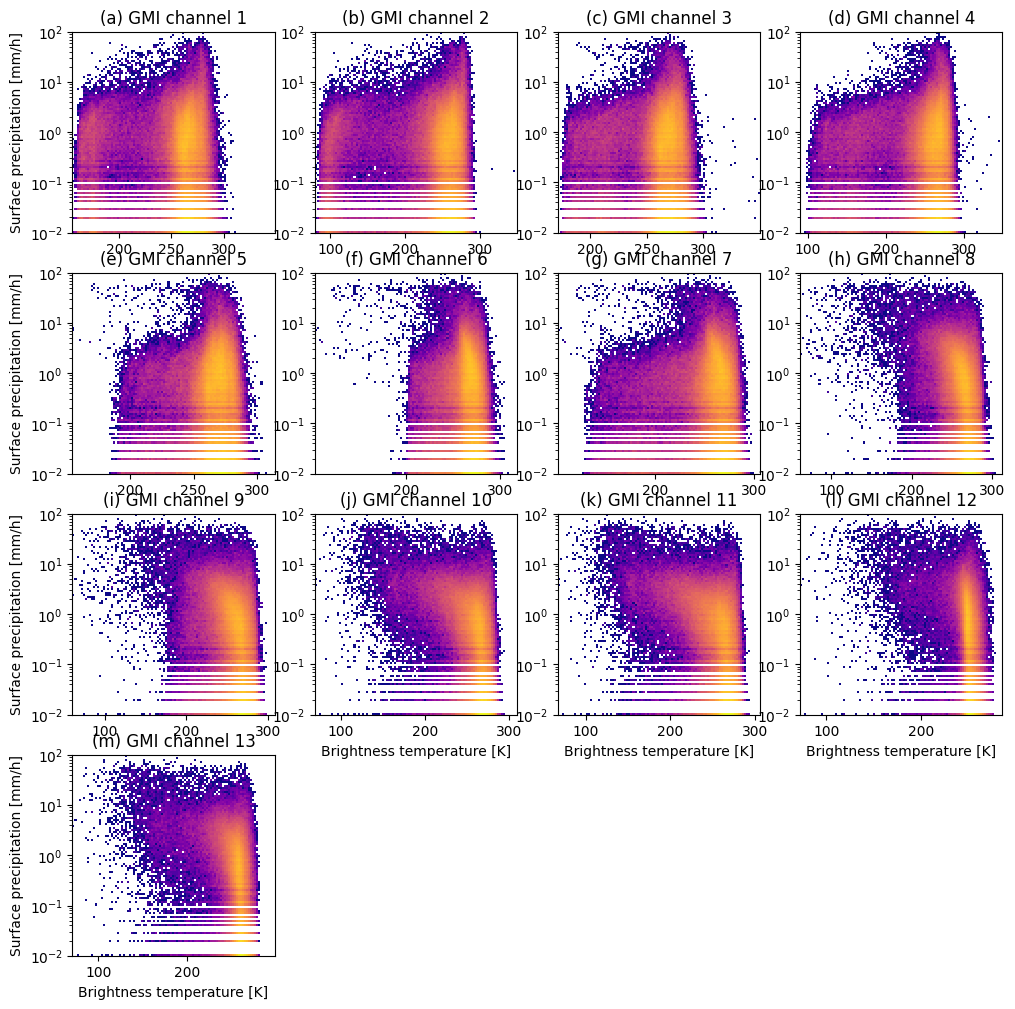

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import numpy as np

n_rows = 4
n_cols = 4
fig = plt.figure(figsize=(3 * n_rows, 3 * n_cols))
gs = GridSpec(n_rows, n_cols)

surface_precip = target_data["surface_precip"].data
surface_precip_bins = np.logspace(-2, 2, 101)

for row_ind in range(4):
    for col_ind in range(4):
        channel_ind = row_ind * 4 + col_ind
        
        if channel_ind > 12:
            continue
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        obs = input_data["observations"][{"channel": channel_ind}]
        obs_bins = np.linspace(obs.min(), obs.max(), 101)
        cts = np.histogram2d(obs, surface_precip, bins=(obs_bins, surface_precip_bins))[0]

        ax.pcolormesh(obs_bins, surface_precip_bins, cts.T, norm=LogNorm(), cmap="plasma")
        ax.set_yscale("log")

        ax.set_title(f"({chr(ord('a') + channel_ind)}) GMI channel {channel_ind + 1}")

        if col_ind == 0:
            ax.set_ylabel("Surface precipitation [mm/h]")

        if channel_ind > 8:
            ax.set_xlabel("Brightness temperature [K]")
        

## Training a simple neural network retrieval

- Below we will use the techniques we learned to train a very basic fully-connected neural network to retrieva surface precipitation

### Preparing the data

- It is common to normalize the input data for neural networks. Below we use min-max normalization to map all input features to the range [-1, 1]
- Neural networks can't handle NAN values. So we replace them with -1.5
- We also convert all input data to torch.Tensors and 32-bit floating point types.

In [7]:
import torch 

obs_min = input_data.observations.min("samples")
obs_max = input_data.observations.max("samples")

obs_n = -1.0  + (input_data.observations - obs_min) / (obs_max - obs_min)
obs = torch.tensor(obs_n.data).to(torch.float32)
obs = torch.nan_to_num(obs, nan=-1.5)

obs = torch.tensor(obs.data).to(torch.float32)
surface_precip = torch.tensor(target_data.surface_precip.data).to(torch.float32)

/tmp/ipykernel_69045/2589277915.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs.data).to(torch.float32)


#### Training and validation datasets

- This time, we split the data into training and validation dataset so that we can use the validation dataset to monitor training progress.

In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(
    obs.reshape(-1, 13),
    surface_precip.reshape(-1, 1)
)
training_data, validation_data = random_split(dataset, (0.8, 0.2))
training_loader = DataLoader(training_data, num_workers=4, batch_size=1024, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=4, batch_size=1024, shuffle=True)

### The neural network

- We use a similar neural network as before but adjust the number of input features to match the number of channels of the GMI sensor.

In [9]:
from torch import nn

mlp = nn.Sequential(
    nn.Linear(13, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

### Training loop

In [10]:
from tqdm import tqdm
from torch.optim import SGD

loss_fn = nn.MSELoss()
optimizer = SGD(mlp.parameters(), lr=5e-2)

n_epochs = 100

for epoch_index in range(n_epochs):

    tot_loss = 0.0
    n_samples = 0
    
    for x_b, y_b in tqdm(training_loader):
        
        loss = loss_fn(y_b, mlp(x_b))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    val_loss = 0
    for x_b, y_b in validation_loader:
        with torch.no_grad():
            y_pred = mlp(x_b)
            val_loss += loss_fn(y_b, y_pred).item()

    print(f"Epoch {epoch_index}, Validation loss: {val_loss / len(validation_loader)}")


100%|████████████████████████████████████████████████████| 2547/2547 [00:16<00:00, 151.44it/s]


Epoch 0, Validation loss: 0.759843575810572


100%|████████████████████████████████████████████████████| 2547/2547 [00:18<00:00, 136.02it/s]


Epoch 1, Validation loss: 0.7004083456176229


100%|████████████████████████████████████████████████████| 2547/2547 [00:19<00:00, 131.71it/s]


Epoch 2, Validation loss: 0.6891911170873761


100%|█████████████████████████████████████████████████████| 2547/2547 [00:26<00:00, 94.33it/s]


Epoch 3, Validation loss: 0.6862305660601968


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 107.53it/s]


Epoch 4, Validation loss: 0.6765221424073309


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 104.61it/s]


Epoch 5, Validation loss: 0.6422160079226108


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 120.21it/s]


Epoch 6, Validation loss: 0.6828539495120992


100%|████████████████████████████████████████████████████| 2547/2547 [00:22<00:00, 112.31it/s]


Epoch 7, Validation loss: 0.6330115676329733


100%|████████████████████████████████████████████████████| 2547/2547 [00:22<00:00, 113.99it/s]


Epoch 8, Validation loss: 0.6044370891757345


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 99.21it/s]


Epoch 9, Validation loss: 0.6066775270379506


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 117.75it/s]


Epoch 10, Validation loss: 0.9132575286520145


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 117.64it/s]


Epoch 11, Validation loss: 0.7884752383131061


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 108.07it/s]


Epoch 12, Validation loss: 0.6013324511130713


100%|█████████████████████████████████████████████████████| 2547/2547 [00:26<00:00, 95.62it/s]


Epoch 13, Validation loss: 0.5693707955618107


100%|████████████████████████████████████████████████████| 2547/2547 [00:22<00:00, 111.05it/s]


Epoch 14, Validation loss: 0.6488064731730022


100%|████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 121.52it/s]


Epoch 15, Validation loss: 0.7262953274665486


100%|████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 101.36it/s]


Epoch 16, Validation loss: 0.7788775377267946


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 108.57it/s]


Epoch 17, Validation loss: 0.5810605101345847


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 116.13it/s]


Epoch 18, Validation loss: 0.562653276542994


 13%|██████▉                                               | 330/2547 [00:04<00:27, 80.61it/s]


KeyboardInterrupt: 

## Results

- The ``ipwgml`` package provide built-in functionality to evaluate any ML precipitation retrieval.
- For this, we need to define only need to define a callback object that runs our NN retrieval on given input data

In [11]:
class RetrievalCallback:
    """
    A callable that run the given PyTorch model on IPWGML
    retrieval test data.
    """
    def __init__(self, model: nn.Module):
        """
        Args:
            model: The trained PyTorch model implemented the retrieval.
        """
        self.model = model
        
    def __call__(self, input_data: xr.Dataset) -> xr.Dataset:
    
        input_data = input_data.transpose("batch", "channels_gmi")

        # Don't forget to normalize your input data in the exact same
        # way during inference as during training
        obs = input_data.obs_gmi.data
        obs_n = -1.0 +(obs - obs_min.data) / (obs_max.data - obs_min.data)
        obs = torch.nan_to_num(torch.tensor(obs_n).to(torch.float32), nan=-1.5)

        with torch.no_grad():
            surface_precip = mlp(obs)
    
        return xr.Dataset({
            "surface_precip": (("samples",), surface_precip[..., 0])
        })

### Case study

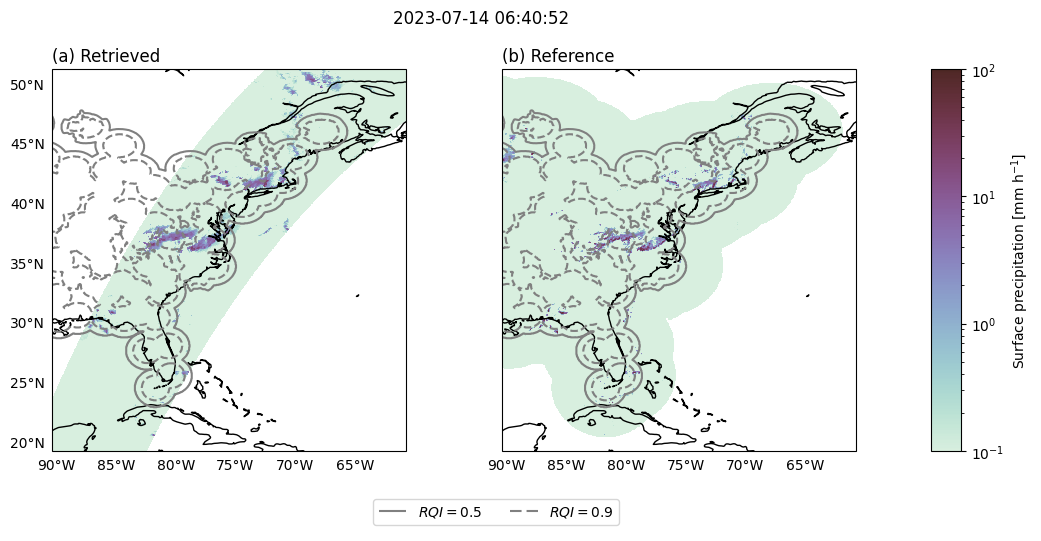

In [14]:
from ipwgml.evaluation import Evaluator

retrieval_fn = RetrievalCallback(mlp)
evaluator = Evaluator(
    reference_sensor="gmi",
    geometry="on_swath",
    retrieval_input=["gmi"],
)
evaluator.plot_retrieval_results(
    scene_index=86,
    retrieval_fn=retrieval_fn,
    input_data_format="tabular",
    batch_size=1024
);

### Retrieval metrics

- The ``evaluate`` runs the retrieval over all scenes in the test dataset and assesses the results using various metrics

In [15]:
evaluator.evaluate(
    retrieval_fn=retrieval_fn, 
    input_data_format="tabular",
)

Output()

In [16]:
baseline_results = evaluator.get_precip_quantification_results(name="Simple NN")
baseline_results

/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/ipwgml/metrics.py:672: RuntimeWarning: divide by zero encountered in divide
  scales = 0.5 * (N - 1) * self.scale / n


,Bias [$\%$],MAE [$mm h^{-1}$],MSE [$(mm h^{-1})^2$],SMAPE$_{0.1}$ [$\%$],Correlation coeff. [],Effective resolution [$^\circ$]
Simple NN,10.898728,0.143613,1.588481,98.680042,0.595924,0.186
IMERG Final V7 (GMI),-7.398772,0.124924,1.731411,114.417614,0.455411,inf
GPROF V7 (GMI),5.799770,0.119785,1.413339,91.327371,0.552348,0.423


## Excercise

- Try to improve upon the performance of the Simple NN aboe.
- Thing you may want to try:
  - Use the training split of the SPR dataset
  - Train for more epochs
  - Reduce the learning rate towards the end of the training
  - Use a different optimizer
  - Try learning rate schedules
  - Use a deeper model
  - Use a wider model
  